### YELP Reviews Analysis for Business Improvement


### setup


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import textblob as tb

Read Reviews and Business Dataset

In [4]:
review_df = pd.read_csv('../Dataset/yelp_review.csv')
business_df = pd.read_csv('../Dataset/yelp_business.csv')

In [5]:
print("reviews dataset:", review_df.columns )
print(review_df.head())


reviews dataset: Index(['review_id', 'user_id', 'business_id', 'stars', 'date', 'text',
       'useful', 'funny', 'cool'],
      dtype='object')
                review_id                 user_id             business_id  \
0  vkVSCC7xljjrAI4UGfnKEQ  bv2nCi5Qv5vroFiqKGopiw  AEx2SYEUJmTxVVB18LlCwA   
1  n6QzIUObkYshz4dz2QRJTw  bv2nCi5Qv5vroFiqKGopiw  VR6GpWIda3SfvPC-lg9H3w   
2  MV3CcKScW05u5LVfF6ok0g  bv2nCi5Qv5vroFiqKGopiw  CKC0-MOWMqoeWf6s-szl8g   
3  IXvOzsEMYtiJI0CARmj77Q  bv2nCi5Qv5vroFiqKGopiw  ACFtxLv8pGrrxMm6EgjreA   
4  L_9BTb55X0GDtThi6GlZ6w  bv2nCi5Qv5vroFiqKGopiw  s2I_Ni76bjJNK9yG60iD-Q   

   stars        date                                               text  \
0      5  2016-05-28  Super simple place but amazing nonetheless. It...   
1      5  2016-05-28  Small unassuming place that changes their menu...   
2      5  2016-05-28  Lester's is located in a beautiful neighborhoo...   
3      4  2016-05-28  Love coming here. Yes the place always needs t...   
4      4  2016-05

In [6]:
print("business dataset:", business_df.columns)
print(business_df.head())

business dataset: Index(['business_id', 'name', 'neighborhood', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'stars', 'review_count',
       'is_open', 'categories'],
      dtype='object')
              business_id                        name neighborhood  \
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"          NaN   
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"          NaN   
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"          NaN   
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"          NaN   
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"          NaN   

                            address            city state postal_code  \
0        "4855 E Warner Rd, Ste B9"       Ahwatukee    AZ       85044   
1              "3101 Washington Rd"        McMurray    PA       15317   
2          "6025 N 27th Ave, Ste 1"         Phoenix    AZ       85017   
3  "5000 Arizona Mills Cr, Ste 435"           Tempe    AZ       8528

### PreProcess

Fetch name of the business is business_name_df

In [7]:
name_df = business_df[['business_id', 'name']]
print(name_df.head(5))

              business_id                        name
0  FYWN1wneV18bWNgQjJ2GNg          "Dental by Design"
1  He-G7vWjzVUysIKrfNbPUQ       "Stephen Szabo Salon"
2  KQPW8lFf1y5BT2MxiSZ3QA     "Western Motor Vehicle"
3  8DShNS-LuFqpEWIp0HxijA          "Sports Authority"
4  PfOCPjBrlQAnz__NXj9h_w  "Brick House Tavern + Tap"


Since we have business_id( unique ) in both the df's , let's merge it.

In [8]:
review_df = pd.merge(review_df, name_df, how = 'left', left_on = 'business_id', right_on = 'business_id')
review_df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,"""Wilensky's"""
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,"""Tuck Shop"""
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,"""Lester's Deli"""
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,"""Five Guys"""
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,"""Maison Christian Faure"""


In [9]:
#Stroing in to csv
#review_df.head(1000).to_csv('business_reviews.csv', encoding='utf-8')

Word Stemming


In [10]:
"""
i.e. Form a tree of words with the same meaning, where root would be the main keyword. 
look (root)
/          \
looking    looked   
"""

'\ni.e. Form a tree of words with the same meaning, where root would be the main keyword. \nlook (root)\n/          looking    looked   \n'

Tokeninze

In [11]:
"""
also tokenize the tokens so we're only getting words, including those with apostrophes. Below is a function to pass through as an argument in the TfidfVectorizer to override the tokenizing and to add the stemming.
"""

"\nalso tokenize the tokens so we're only getting words, including those with apostrophes. Below is a function to pass through as an argument in the TfidfVectorizer to override the tokenizing and to add the stemming.\n"

In [12]:
snowball = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [snowball.stem(word) for word in tokenizer.tokenize(text.lower())]

vectorize the words of the corpus 

In [13]:
""" 
Putiing the same meaning words in one vector
(look, looked, looking)
"""

' \nPutiing the same meaning words in one vector\n(look, looked, looking)\n'

In [14]:
#this function returns tfidf matrix
def vectorize_reviews(reviews):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, max_features = 1000)
    X = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return X, words

### Each cluster that kMeans finds is a general topic of the reviews as a whole and is represented by words or groups of words. 


Each dimension in the cluster center coordinates is the relative frequency for a word in that cluster. 

We can find the indices of the words with highest frequency in each cluster and these indices correspond to their respective word in the array of tokens.

 That way we can take a look at the words that represent the clusters the most and get an idea of what the latent topics are.

In [15]:
def print_clusters(company_id, K = 8, num_words = 10):
    company_df = review_df[review_df['business_id'] == company_id]
    company_name = company_df['name'].unique()[0]
    reviews = company_df['text'].values
    X, words = vectorize_reviews(reviews)
    
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(X)
    
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1]
    print('Groups of ' + str(num_words) + ' words typically used together in reviews for ' + \
          company_name)
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

#total number of unique business


In [16]:
print(review_df['business_id'].unique)

<bound method Series.unique of 0          AEx2SYEUJmTxVVB18LlCwA
1          VR6GpWIda3SfvPC-lg9H3w
2          CKC0-MOWMqoeWf6s-szl8g
3          ACFtxLv8pGrrxMm6EgjreA
4          s2I_Ni76bjJNK9yG60iD-Q
                    ...          
5261663    Ngk84Ax1tXgpoJFEGxot3w
5261664    pOEL97ld-FJMKO8Ki8JmYg
5261665    5ubokMNw8qfbX2WtxgJG1Q
5261666    EO3i5kTUG7_S2OIQ23sdSA
5261667    HloEEXm_QzEpycuwA_RtQA
Name: business_id, Length: 5261668, dtype: object>


In [17]:
most_reviewed_business = review_df['business_id'].mode()
print(most_reviewed_business)


0    4JNXUYY8wbaaDmk3BPzlWw
dtype: object


In [18]:
company_df = review_df[review_df['business_id'] == "4JNXUYY8wbaaDmk3BPzlWw"]
company_name = company_df['name'].unique()[0]


In [19]:
print(company_name)

"Mon Ami Gabi"


### Let's work on mostly reviewed business "Mon Ami Gabi"

<AxesSubplot: xlabel='stars', ylabel='count'>

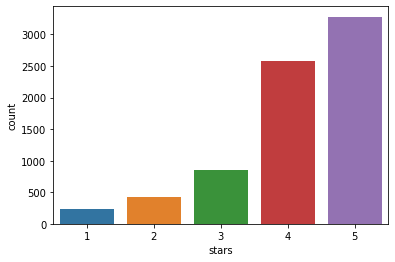

In [20]:
bus_id = '4JNXUYY8wbaaDmk3BPzlWw'
company_df = review_df[review_df['business_id'] == bus_id]
sns.countplot(x = company_df['stars'])

Randomly choosing k = 5 and let's take top 12 words

### Groups of 12 words typically used together in reviews for "Mon Ami Gabi"

In [21]:
print_clusters(bus_id, K = 5, num_words = 12)


/Users/grishptl/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/Users/grishptl/opt/anaconda3/lib/python3.9/site-pa

Groups of 12 words typically used together in reviews for "Mon Ami Gabi"
0 : great, bellagio, fountain, view, food, watch, patio, outsid, place, sit, strip, peopl
1 : breakfast, egg, benedict, toast, hash, waffl, coffe, good, great, brunch, crepe, place
2 : mon, ami, gabi, vega, restaur, great, time, food, steak, french, good, place
3 : food, great, servic, good, place, veri, vega, time, restaur, price, excel, steak
4 : steak, order, good, veri, like, french, soup, realli, bread, frite, onion, fri


Let's also add ngrams to understand meaning better

### TFIDF Vectorizing and saving file to csv

In [22]:
def save_tfidf_file(x_data, y_columns):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, \
                        min_df = 0.0025, max_df = 0.05, max_features = 1000, ngram_range = (1, 3))
    count_array = x_data.toarray()
    df = pd.DataFrame(data=count_array,columns = y_columns)
    df.to_csv("../Dataset/vectorizer_output.csv.gz", sep='\t', compression='gzip')
    print("vectorizer output file generated")


In [23]:
#Unigram = 1, Bigram= 2, ...ngram
#to understand meaning in token of reviews
def vectorize_reviews2(reviews):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, \
                        min_df = 0.0025, max_df = 0.05, max_features = 1000, ngram_range = (1, 3))
    X = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    save_tfidf_file(x_data=X, y_columns = words)
    return X, words

In [24]:
def print_clusters2(company_id, K = 8, num_words = 10):
    company_df = review_df[review_df['business_id'] == company_id]
    company_name = company_df['name'].unique()[0]
    reviews = company_df['text'].values
    """
    Let's use updated reviews
    
    """
    X, words = vectorize_reviews2(reviews)
    #print(X,words)
    kmeans = KMeans(n_clusters = K)
    kmeans.fit(X)
    
    common_words = kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1]
    print('Groups of ' + str(num_words) + ' words typically used together in reviews for ' + \
          company_name)
    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

### Again random K and num_words with ngram range from 1to 3

In [25]:
print_clusters2(bus_id, K = 3, num_words = 12)


vectorizer output file generated
Groups of 12 words typically used together in reviews for "Mon Ami Gabi"
0 : great food, great servic, food great, waffl, french toast, good food, free, food good, gluten, food servic, love place, sit patio
1 : mari, bloodi, bloodi mari, mari bar, bloodi mari bar, waffl, mimosa, hash, sunday, quich, french toast, fun
2 : seafood, mussel, hash, goat, goat chees, merlot, meat, bake, thought, group, brie, boyfriend


### K- Means Model Evaluation Quality of Clusters - K-means

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:

First initialize  centroids randomly:  distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
Repeat until convergence (i.e., until the centroids stop moving):
Assign each instance to the closest centroid.
Update the centroids to be the mean of the instances that are assigned to them.
The KMeans class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set init="random", n_init=1and algorithm="full". These hyperparameters will be explained below.



We will apply two evaluation methods, Inertia and Silhouette score.

Please read the documentation of these two methods:

https://scikit-learn.org/stable/modules/clustering.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

Find Optimal k values based on the evaluation.

In [26]:
print(company_df.head(5))

                   review_id                 user_id             business_id  \
1720  YCzBgTYCyTtPAe2v8_GGKA  CZs1Eq7t1fqpXV1yox-CVg  4JNXUYY8wbaaDmk3BPzlWw   
2399  lPf1wwTu9VeWABHDPhu2tA  Zqk-ye_OHeH_sS1JsdsLgg  4JNXUYY8wbaaDmk3BPzlWw   
3430  voVb586hGvZC6vUA7HUIIw  RmThjWcv7x5Z_vVuOlRNwQ  4JNXUYY8wbaaDmk3BPzlWw   
7921  jipTZe7L20v422d2Di2_Tw  hBl_w9Rmn_Bz0HiMzwaknA  4JNXUYY8wbaaDmk3BPzlWw   
8793  D5r-QLswHpnxaMadQdi_dg  eZ5I1bHkdXoGOFKn_oOFFQ  4JNXUYY8wbaaDmk3BPzlWw   

      stars        date                                               text  \
1720      4  2017-10-25  Traditional French fare at the heart of the La...   
2399      5  2013-10-15  This is my go to place for the last 12 years, ...   
3430      2  2017-04-03  Mediocre food for too much money, at least at ...   
7921      4  2012-12-26  My family and I had dinner here and the wait w...   
8793      5  2015-10-21  Patio dining at its best. Steak au poive with ...   

      useful  funny  cool            name  
1720  

### silhouette_score : to evaluate k-cluster

/Users/grishptl/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/Users/grishptl/opt/anaconda3/lib/python3.9/site-pa

vectorizer output file generated


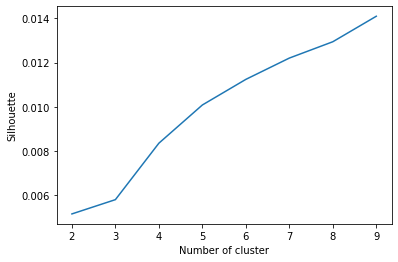

In [27]:

reviews = company_df['text'].values
X, words = vectorize_reviews2(reviews)
data = X
from sklearn import metrics

data = X

score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(X, labels, metric='euclidean')

plt.figure()
plt.plot(list(score.keys()), list(score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")
plt.show()

